In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import grad, jit

from jax.tree_util import tree_map
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import optax

from flax import linen as nn
from flax.training import train_state
from flax.serialization import (
    to_state_dict, msgpack_serialize, from_bytes
)

import os
import wandb
from typing import Callable
from tqdm.notebook import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
ecom_data = pd.read_csv('/kaggle/input/jax-datasets/ecommerce_data.csv')
ecom_data.head()

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",Violet,34.497268,12.655651,39.577668,4.082621,587.951054
1,hduke@hotmail.com,"4547 Archer Common\nDiazchester, CA 06566-8576",DarkGreen,31.926272,11.109461,37.268959,2.664034,392.204933
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\nCobbborough, D...",Bisque,33.000915,11.330278,37.110597,4.104543,487.547505
3,riverarebecca@gmail.com,"1414 David Throughway\nPort Jason, OH 22070-1220",SaddleBrown,34.305557,13.717514,36.721283,3.120179,581.852344
4,mstephens@davidson-herman.com,"14023 Rodriguez Passage\nPort Jacobville, PR 3...",MediumAquaMarine,33.330673,12.795189,37.536653,4.446308,599.406092


In [3]:
ecom_data = ecom_data.drop(['Email','Avatar','Address'], axis = 1)
ecom_data.shape

(500, 5)

In [4]:
X = ecom_data.drop('Yearly Amount Spent', axis = 1)
y = ecom_data['Yearly Amount Spent']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 4), (100, 4), (400,), (100,))

In [6]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [7]:
X_train_scaled.describe()

,Avg. Session Length,Time on App,Time on Website,Length of Membership
count,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02
mean,-5.098144e-15,-7.593925e-16,1.700862e-15,6.439294e-16
std,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00
min,-3.451908e+00,-3.565836e+00,-2.620628e+00,-3.222211e+00
25%,-6.933884e-01,-6.642977e-01,-7.185175e-01,-5.914215e-01
50%,2.992822e-02,-6.535702e-02,-6.221168e-04,8.259965e-03
75%,6.701273e-01,6.835336e-01,6.565832e-01,5.958352e-01
max,3.064394e+00,3.101384e+00,2.968182e+00,2.867555e+00


In [8]:
X_train, X_test, y_train, y_test = jnp.array(X_train_scaled.to_numpy(), dtype = jnp.float32), jnp.array(X_test_scaled.to_numpy(), dtype = jnp.float32), jnp.array(y_train.to_numpy(), dtype = jnp.float32), jnp.array(y_test.to_numpy(), dtype = jnp.float32)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 4), (100, 4), (400,), (100,))

In [9]:
W = jnp.zeros(X_train.shape[1:])

b = 0.

lr = 0.01

n_iter = 500

In [10]:
def predict_y(W, b, X):
    return jnp.dot(X, W) + b

In [11]:
def loss_fn(W, b, X, y):
    error = predict_y(W, b, X) - y
    return jnp.mean(jnp.square(error))

In [12]:
def update_W(W, b, X, y, lr):
    grad_W = grad(loss_fn, argnums = 0)(W, b, X, y)
    
    return tree_map(lambda W, graad_W, lr : W - lr*grad_W, W, grad_W, lr)
    
def update_b(W, b, X, y, lr):    
    grad_b = grad(loss_fn, argnums = 1)(W, b, X, y)
    
    return tree_map(lambda b, graad_b, lr : b - lr*grad_b, b, grad_b, lr)

In [13]:
loss_hist = []

for i in range(n_iter):
    loss = loss_fn(W,b, X_train, y_train)
    
    if (i + 1) % 100 == 0:
        print ('Iteration', i+1, 'Loss:', loss)
        
    loss_hist.append(loss)
    
    W = jit(update_W)(W, b, X_train, y_train, lr)
    b = jit(update_b)(W, b, X_train, y_train, lr)    

Iteration 100 Loss: 4741.1343
Iteration 200 Loss: 189.6363
Iteration 300 Loss: 109.75562
Iteration 400 Loss: 108.3531
Iteration 500 Loss: 108.32845


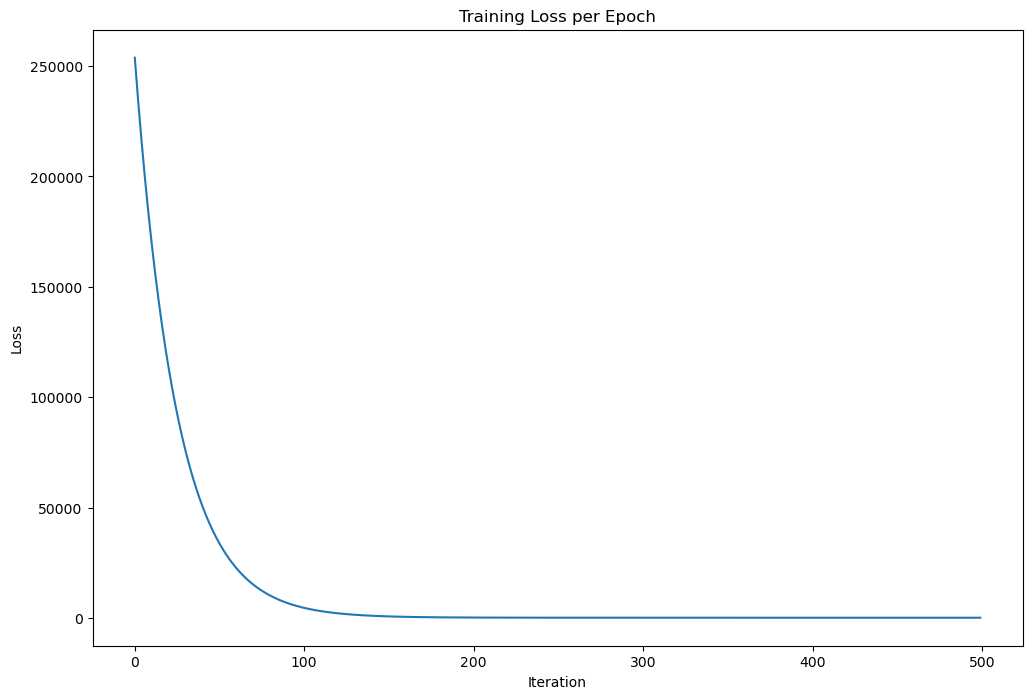

In [14]:
_, ax = plt.subplots(figsize = (12,8))
    
ax.set(xlabel = 'Iteration', ylabel = 'Loss', title = 'Training Loss per Epoch')
plt.plot(loss_hist)   

In [15]:
y_pred = predict_y(W, b, X_test)

In [16]:
print('Test Score: ', r2_score(y_test, y_pred))

Test Score:  0.9720753088883549


In [17]:
def ll_distance(x, y):
    assert x.ndim == y.ndim == 1
    return jnp.sum(jnp.abs(x - y))

In [18]:
xs = jax.random.normal(jax.random.PRNGKey(0), (100, 3))

In [19]:
print(xs)

[[-3.27029943e-01 -2.39483500e+00  5.27334154e-01]
 [ 2.73018098e+00  1.49146700e+00 -4.98553455e-01]
 [ 2.45557591e-01  9.57737625e-01  2.51956677e+00]
 [ 3.62148643e-01  1.85689509e-01  3.22470903e-01]
 [ 1.45681572e+00  8.80274355e-01 -4.10529941e-01]
 [-5.53439140e-01 -6.63070858e-01 -1.03873634e+00]
 [ 1.29981065e+00 -1.01823425e+00  1.54215944e+00]
 [-9.11923170e-01 -1.52895701e+00 -8.08468521e-01]
 [ 1.09811497e+00 -3.01340580e+00 -2.74276876e+00]
 [-6.66993141e-01  3.57444793e-01  2.99840778e-01]
 [-1.76091433e+00 -1.34618032e+00 -6.48179054e-01]
 [ 5.64585984e-01  2.60319173e-01  1.64202332e-01]
 [ 1.34949267e-01 -5.00902712e-01  1.66844606e+00]
 [ 2.08276752e-02 -1.00259495e+00 -5.65370262e-01]
 [-5.71412325e-01  4.14384782e-01  6.96963727e-01]
 [-1.61343205e+00  2.05283299e-01  1.01975763e+00]
 [-1.96275556e+00  4.71469760e-02 -3.03687525e+00]
 [ 6.59111798e-01 -1.67674363e-01  1.02264039e-01]
 [ 3.16516578e-01 -6.57671243e-02  2.00871801e+00]
 [-2.11180314e-01 -8.38562287e-

In [20]:
def pairwise_distances(dist, xs):
    return jax.vmap(jax.vmap(dist, (0, None)), (None, 0))(xs, xs)

ys = pairwise_distances(ll_distance, xs)
print(ys[0])

[0.         7.9694004  5.9173927  3.4745662  5.9968195  3.5242438
 4.0182667  2.786574   5.313819   3.3197362  3.6580524  3.9099019
 3.4970233  2.832802   3.2232318  4.378944   7.641917   3.6383724
 4.4539986  4.5627317  4.017364   5.654166   6.446743   6.5800343
 4.6982055  4.301043   3.8230739  4.816155   3.5797558  2.7555866
 2.548147   1.5514135  2.548323   2.7208908  5.4160924  3.373936
 3.6270401  3.355342   4.006628   1.4261351  3.2753522  4.8054485
 4.536541   5.3197503  4.8530416  6.134207   4.3821106  4.842325
 4.447902   4.847953   3.245659   4.69922    4.0498     4.947985
 5.480611   3.005032   2.7182124  4.970246   5.9698496  3.1156232
 3.0727334  3.8925934  2.5185401  5.079468   3.3377693  5.886614
 6.5018277  5.323314   2.4521265  2.705496   4.5428953  3.9312873
 3.8375168  5.1163855  2.7529204  2.276387   5.2775803  1.7298315
 3.9219236  6.1186824  5.465796   4.2691927  7.091926   4.339386
 4.209691   3.4513159  2.9988804  3.8992567  7.08607    5.5597596
 3.7466297  4.3

In [21]:
import tensorflow as tf
import tensorflow_datasets as tfds

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [22]:
validation_split = 0.2
batch_size = 64

(full_train_set, test_dataset), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


# Similarly, we apply the same transforms to the
# validation and test dataset

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteI8C40F/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteI8C40F/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [23]:
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.
    return image, label

full_train_set = full_train_set.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE
)

num_data = tf.data.experimental.cardinality(
    full_train_set
).numpy()
print("Total number of data points:", num_data)
train_dataset = full_train_set.take(
    num_data * (1 - validation_split)
)
val_dataset = full_train_set.take(
    num_data * (validation_split)
)
print(
    "Number of train data points:",
    tf.data.experimental.cardinality(train_dataset).numpy()
)
print(
    "Number of val data points:",
    tf.data.experimental.cardinality(val_dataset).numpy()
)

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(
    tf.data.experimental.cardinality(train_dataset).numpy()
)
train_dataset = train_dataset.batch(batch_size)

val_dataset = val_dataset.cache()
val_dataset = val_dataset.shuffle(
    tf.data.experimental.cardinality(val_dataset).numpy()
)
val_dataset = val_dataset.batch(batch_size)


test_dataset = test_dataset.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE
)
print(
    "Number of test data points:",
    tf.data.experimental.cardinality(test_dataset).numpy()
    )
test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(batch_size)

Total number of data points: 50000
Number of train data points: 40000
Number of val data points: 10000
Number of test data points: 10000


In [24]:
train_datagen = iter(tfds.as_numpy(train_dataset))
next(train_datagen)[1]

array([8, 8, 9, 8, 5, 5, 3, 8, 8, 9, 1, 9, 8, 1, 9, 2, 1, 9, 7, 4, 9, 4,
       4, 6, 8, 0, 5, 5, 2, 1, 3, 3, 5, 0, 6, 2, 9, 8, 9, 5, 1, 2, 9, 0,
       2, 2, 0, 2, 7, 7, 3, 3, 0, 6, 8, 1, 3, 5, 9, 3, 0, 9, 7, 2])

In [25]:
ds_info

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path=PosixGPath('/tmp/tmpxji42cwmtfds'),
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning mul

# WandB Tut

In [26]:
seed = 42
pooling = "avg"

MODULE_DICT = {
    "avg": nn.avg_pool,
    "max": nn.max_pool,
}

In [27]:
class CNN(nn.Module):
    pool_module: Callable = nn.avg_pool


    def setup(self):
        self.conv_1 = nn.Conv(features=32, kernel_size=(3, 3))
        self.conv_2 = nn.Conv(features=32, kernel_size=(3, 3))
        self.conv_3 = nn.Conv(features=64, kernel_size=(3, 3))
        self.conv_4 = nn.Conv(features=64, kernel_size=(3, 3))
        self.conv_5 = nn.Conv(features=128, kernel_size=(3, 3))
        self.conv_6 = nn.Conv(features=128, kernel_size=(3, 3))
        self.dense_1 = nn.Dense(features=1024)
        self.dense_2 = nn.Dense(features=512)
        self.dense_output = nn.Dense(features=10)


    @nn.compact
    def __call__(self, x):
        x = nn.relu(self.conv_1(x))
        x = nn.relu(self.conv_2(x))
        x = self.pool_module(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.relu(self.conv_3(x))
        x = nn.relu(self.conv_4(x))
        x = self.pool_module(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.relu(self.conv_5(x))
        x = nn.relu(self.conv_6(x))
        x = self.pool_module(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))
        x = nn.relu(self.dense_1(x))
        x = nn.relu(self.dense_2(x))
        return self.dense_output(x)

#     @nn.compact
#     def __call__(self, x):
#         x = nn.relu(nn.Conv(features=32, kernel_size=(3, 3))(x))
#         x = nn.relu(nn.Conv(features=32, kernel_size=(3, 3))(x))
#         x = self.pool_module(x, window_shape=(2, 2), strides=(2, 2))
#         x = nn.relu(nn.Conv(features=64, kernel_size=(3, 3))(x))
#         x = nn.relu(nn.Conv(features=64, kernel_size=(3, 3))(x))
#         x = self.pool_module(x, window_shape=(2, 2), strides=(2, 2))
#         x = nn.relu(nn.Conv(features=128, kernel_size=(3, 3))(x))
#         x = nn.relu(nn.Conv(features=128, kernel_size=(3, 3))(x))
#         x = self.pool_module(x, window_shape=(2, 2), strides=(2, 2))
#         x = x.reshape((x.shape[0], -1))
#         x = nn.relu(nn.Dense(features=1024)(x))
#         x = nn.relu(nn.Dense(features=512)(x))
#         return nn.Dense(features=10)(x)


In [28]:
rng = jax.random.PRNGKey(seed) # PRNG Key
x = jnp.ones(shape=(batch_size, 32, 32, 3)) # Dummy Input
model = CNN(pool_module=MODULE_DICT[pooling]) # Instantiate the Model
params = model.init(rng, x) # Initialize the parameters
jax.tree_map(lambda x: x.shape, params) # Check the parameters

FrozenDict({
    params: {
        conv_1: {
            bias: (32,),
            kernel: (3, 3, 3, 32),
        },
        conv_2: {
            bias: (32,),
            kernel: (3, 3, 32, 32),
        },
        conv_3: {
            bias: (64,),
            kernel: (3, 3, 32, 64),
        },
        conv_4: {
            bias: (64,),
            kernel: (3, 3, 64, 64),
        },
        conv_5: {
            bias: (128,),
            kernel: (3, 3, 64, 128),
        },
        conv_6: {
            bias: (128,),
            kernel: (3, 3, 128, 128),
        },
        dense_1: {
            bias: (1024,),
            kernel: (2048, 1024),
        },
        dense_2: {
            bias: (512,),
            kernel: (1024, 512),
        },
        dense_output: {
            bias: (10,),
            kernel: (512, 10),
        },
    },
})

In [29]:
type(params['params'].keys())

flax.core.frozen_dict.FrozenKeysView

In [30]:
tf.data.experimental.cardinality(train_dataset).numpy()

625

In [31]:
def init_train_state(
    model, random_key, shape, learning_rate
) -> train_state.TrainState:
    # Initialize the Model
    variables = model.init(random_key, jnp.ones(shape))
    # Create the optimizer
    optimizer = optax.adam(learning_rate)
    # Create a State
    return train_state.TrainState.create(
        apply_fn = model.apply,
        tx=optimizer,
        params=variables['params']
    )


learning_rate = 0.01

state = init_train_state(
    model, rng, (batch_size, 32, 32, 3), learning_rate
)

In [32]:
next(iter(tfds.as_numpy(train_dataset)))[0][0].shape

(32, 32, 3)

In [33]:
# model.apply(params, next(iter(tfds.as_numpy(train_dataset)))[0][0].reshape(1,32,32,3))
new_state = state = init_train_state(
    model, rng, (1, 32, 32, 3), learning_rate
)

new_state.apply_fn({'params': new_state.params}, next(iter(tfds.as_numpy(train_dataset)))[0][0].reshape(1,32,32,3))

Array([[-0.03303554, -0.0113703 , -0.02122321,  0.02390327,  0.00644984,
         0.04953827, -0.0126253 ,  0.03831155, -0.02127868, -0.00165611]],      dtype=float32)

In [34]:
params.keys()

frozen_dict_keys(['params'])

In [35]:
params['params']['conv_1']['kernel'].shape

(3, 3, 3, 32)

In [36]:
NUM_DEVICES = jax.device_count()
NUM_DEVICES

2

In [37]:
from jax.experimental import mesh_utils
from jax.sharding import PositionalSharding

In [38]:
x = jnp.arange(64 * 64).reshape(64, 64)
jax.debug.visualize_array_sharding(x)

                         
                         
                         
                         
                         
          GPU 0          
                         
                         
                         
                         
                         

In [39]:
x.sharding

SingleDeviceSharding(device=gpu(id=0))

In [40]:
sharding = PositionalSharding(jax.local_devices())
sharding.reshape(2, 1)

PositionalSharding([[{GPU 0}]
                    [{GPU 1}]])

In [41]:
y = jax.device_put(x, sharding.reshape(2, 1).replicate(0))
jax.debug.visualize_array_sharding(y)

                         
                         
                         
                         
                         
         GPU 0,1         
                         
                         
                         
                         
                         

In [42]:
t = x.reshape(64, 64)
k = jax.device_put(t, sharding.reshape(2, 1))
k = k.reshape(64, 8, 8, 1)
len(k.addressable_shards)

2

In [43]:
t.reshape(8, 8, 64, 1).shape

(8, 8, 64, 1)

In [44]:
@jax.pmap
def g(x):
    return x

p = g(t.reshape(2, 32, 64, 1))
p.sharding

PmapSharding(sharding_spec=ShardingSpec((Unstacked(2), NoSharding(), NoSharding(), NoSharding()), (ShardedAxis(axis=0),)), devices=[gpu(id=0) gpu(id=1)])

In [52]:
new_ds = (jax.random.normal(jax.random.PRNGKey(1234), (1,32,32,3)).max()-jax.random.normal(jax.random.PRNGKey(1234), (1,32,32,3)))/(jax.random.normal(jax.random.PRNGKey(1234), (1,32,32,3)).max()-jax.random.normal(jax.random.PRNGKey(1234), (1,32,32,3)).min())
new_state.apply_fn({'params': new_state.params}, new_ds)

Array([[-0.03610136, -0.0116248 , -0.01477495,  0.03067864, -0.00107725,
         0.04890758, -0.01225487,  0.03980496, -0.0220595 ,  0.00222602]],      dtype=float32)

Array([[[[0.65872943, 0.4778591 , 0.3777862 ],
         [0.40293947, 0.47538754, 0.56898993],
         [0.42710724, 0.3903623 , 0.60238916],
         ...,
         [0.573416  , 0.59105426, 0.5174552 ],
         [0.4529719 , 0.4713363 , 0.6895895 ],
         [0.46136218, 0.7718048 , 0.3748058 ]],

        [[0.50742507, 0.79812026, 0.4878209 ],
         [0.48573947, 0.5705354 , 0.6535218 ],
         [0.515039  , 0.62227315, 0.47032526],
         ...,
         [0.41700536, 0.593702  , 0.67545956],
         [0.28516528, 0.47359237, 0.4207293 ],
         [0.47094378, 0.564563  , 0.59437776]],

        [[0.49287537, 0.20526265, 0.550291  ],
         [0.5162196 , 0.47847775, 0.7355742 ],
         [0.23392707, 0.24794671, 0.5924224 ],
         ...,
         [0.41266015, 0.39832637, 0.5393204 ],
         [0.41818324, 0.44660214, 0.6588665 ],
         [0.5701903 , 0.49143752, 0.4840439 ]],

        ...,

        [[0.5905704 , 0.6251463 , 0.5670925 ],
         [0.6546623 , 0.7849769 , 0.794957  ]